In [ ]:
!pip install torch
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/diabetes_012_health_indicators_BRFSS2015/diabetes_012_health_indicators_BRFSS2015.csv'
data = pd.read_csv(data_file)

# Define features and target
X = data.iloc[:, :-1]
y = data.iloc[:, 0]


# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Convert training and testing data to tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.long)

# Dynamically create an edge index for each dataset size
def create_edge_index(num_nodes):
    edges = [[i, i + 1] for i in range(num_nodes - 1)] + [[i + 1, i] for i in range(num_nodes - 1)]
    return torch.tensor(edges, dtype=torch.long).T

edge_index_train = create_edge_index(X_train.shape[0])
edge_index_test = create_edge_index(X_test.shape[0])

# Normalize feature data
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float)

# Create Data objects for training and testing
train_data = Data(x=X_train, edge_index=edge_index_train, y=y_train)
test_data = Data(x=X_test, edge_index=edge_index_test, y=y_test)


# Define GNN model with Dropout
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels=X_train.shape[1], out_channels=32)
        self.conv2 = GCNConv(in_channels=32, out_channels=16)
        self.fc = torch.nn.Linear(16, 2)
        self.dropout = torch.nn.Dropout(p=0.5)  # Apply dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after activation
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after activation
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Initialize model, optimizer, and loss function
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.NLLLoss()

# Training loop
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Train model
epochs = 1000
for epoch in range(epochs):
    loss = train(train_data)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Testing the model
model.eval()
with torch.no_grad():
    pred = model(test_data).argmax(dim=1)
    accuracy = (pred == test_data.y).sum().item() / test_data.num_nodes
    print(f'Accuracy: {accuracy:.4f}')



Epoch 0, Loss: 0.6393
Epoch 10, Loss: 0.5848
Epoch 20, Loss: 0.5334
Epoch 30, Loss: 0.4980
Epoch 40, Loss: 0.4815
Epoch 50, Loss: 0.4621
Epoch 60, Loss: 0.4545
Epoch 70, Loss: 0.4580
Epoch 80, Loss: 0.4379
Epoch 90, Loss: 0.4308
Epoch 100, Loss: 0.4042
Epoch 110, Loss: 0.3936
Epoch 120, Loss: 0.3942
Epoch 130, Loss: 0.4347
Epoch 140, Loss: 0.4091
Epoch 150, Loss: 0.3943
Epoch 160, Loss: 0.3694
Epoch 170, Loss: 0.3852
Epoch 180, Loss: 0.3992
Epoch 190, Loss: 0.4142
Epoch 200, Loss: 0.3715
Epoch 210, Loss: 0.3867
Epoch 220, Loss: 0.3747
Epoch 230, Loss: 0.3449
Epoch 240, Loss: 0.3435
Epoch 250, Loss: 0.3353
Epoch 260, Loss: 0.3801
Epoch 270, Loss: 0.3554
Epoch 280, Loss: 0.3875
Epoch 290, Loss: 0.3362
Epoch 300, Loss: 0.3150
Epoch 310, Loss: 0.3691
Epoch 320, Loss: 0.3347
Epoch 330, Loss: 0.3565
Epoch 340, Loss: 0.3812
Epoch 350, Loss: 0.3143
Epoch 360, Loss: 0.3872
Epoch 370, Loss: 0.3962
Epoch 380, Loss: 0.3322
Epoch 390, Loss: 0.3298
Epoch 400, Loss: 0.3046
Epoch 410, Loss: 0.3356
Epo

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Paths to the train and test directories
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/heart+failure+clinical+records/heart_failure_clinical_records_dataset.csv'

# Load the CSV file
data = pd.read_csv(data_file)

# Make the last column the target variable (mortality)
X = data.iloc[:, :-1]  # All columns except the last
y = data.iloc[:, -1]   # Last column as target (mortality)

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify shapes of the splits
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")

features = torch.tensor([
    [65, 1, 150, 0, 20, 0, 300000, 1.1, 140, 1],  # patient 1
    [50, 0, 200, 1, 35, 1, 250000, 1.0, 135, 0],  # patient 2
    [70, 1, 120, 0, 25, 1, 280000, 1.2, 142, 1],  # patient 3
    [80, 1, 180, 1, 30, 0, 320000, 0.9, 137, 0],  # patient 4
    [55, 0, 220, 0, 40, 1, 290000, 1.3, 130, 1]   # patient 5
], dtype=torch.float)

# Target labels for mortality (0 = survived, 1 = deceased)
targets = torch.tensor([1, 0, 1, 0, 1], dtype=torch.long)

# Example edges (connections between patients)
# For simplicity, we connect each node to its adjacent ones
edges = torch.tensor([
    [0, 1, 1, 2, 2, 3, 3, 4],
    [1, 0, 2, 1, 3, 2, 4, 3]
], dtype=torch.long)

# Create graph data object
data = Data(x=features, edge_index=edges, y=targets)

# Define the GNN model using Graph Convolutional Network (GCN) layers
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels=features.shape[1], out_channels=16)
        self.conv2 = GCNConv(in_channels=16, out_channels=8)
        self.fc = torch.nn.Linear(8, 2)  # Output 2 classes for mortality prediction

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Initialize model, optimizer, and loss function
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.NLLLoss()

# Training loop
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training the model
epochs = 1000
for epoch in range(epochs):
    loss = train(data)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Testing the model
model.eval()
with torch.no_grad():
    pred = model(data).argmax(dim=1)
    accuracy = (pred == data.y).sum() / data.num_nodes
    print(f'Accuracy: {accuracy:.4f}')



Training set shape: X_train=(239, 12), y_train=(239,)
Testing set shape: X_test=(60, 12), y_test=(60,)


In [ ]:

# Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load CSV Data
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/heart+failure+clinical+records/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(data_file)

# Split Features and Target
X = data.iloc[:, :-1].values  # All columns except the last
y = data.iloc[:, -1].values   # Last column as target (mortality)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Define the Feature Extractor Neural Network
class FeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, output_dim=8):
        super(FeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))  # Extracted features layer
        return x

# Initialize Feature Extractor
input_dim = X_train.shape[1]
feature_extractor = FeatureExtractor(input_dim=input_dim)

# Set up optimizer and loss function
optimizer = optim.Adam(feature_extractor.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Train Feature Extractor
epochs = 100
for epoch in range(epochs):
    feature_extractor.train()
    optimizer.zero_grad()
    features = feature_extractor(X_train_tensor)
    loss = loss_fn(features, features)  # Self-supervised or placeholder loss
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Extract Features for Logistic Regression
with torch.no_grad():
    X_train_features = feature_extractor(X_train_tensor).numpy()
    X_test_features = feature_extractor(X_test_tensor).numpy()

# Train Logistic Regression on Extracted Features
clf = LogisticRegression()
clf.fit(X_train_features, y_train)
y_pred = clf.predict(X_test_features)

# Calculate and Print Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Epoch 0, Loss: 0.0
Epoch 10, Loss: 0.0
Epoch 20, Loss: 0.0
Epoch 30, Loss: 0.0
Epoch 40, Loss: 0.0
Epoch 50, Loss: 0.0
Epoch 60, Loss: 0.0
Epoch 70, Loss: 0.0
Epoch 80, Loss: 0.0
Epoch 90, Loss: 0.0
Accuracy: 0.8000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


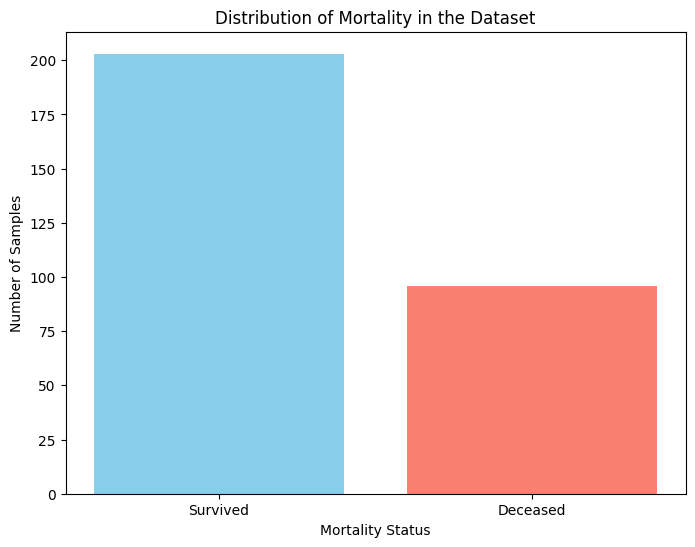

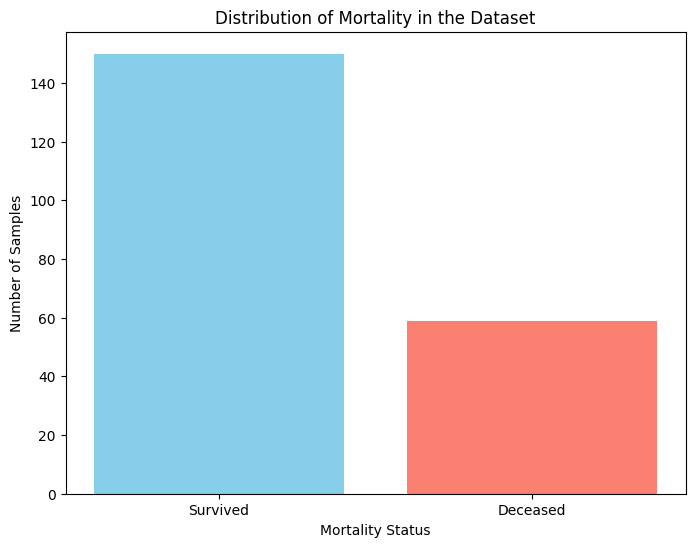

Confusion Matrix:
[[33  2]
 [10 15]]
Accuracy: 0.8000
Precision: 0.8824
Recall: 0.6000
F1 Score: 0.7143
Specificity: 0.9429


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Load CSV Data
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/heart+failure+clinical+records/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(data_file)

# Check the distribution of the target variable (assuming 'mortality' is binary: 1 = positive, 0 = negative)
target_counts = data.iloc[:, -1].value_counts()  # Assuming last column is the target (mortality)

# Plot distribution
plt.figure(figsize=(8, 6))
plt.bar(['Survived', 'Deceased'], target_counts, color=['skyblue', 'salmon'])
plt.xlabel('Mortality Status')
plt.ylabel('Number of Samples')
plt.title('Distribution of Mortality in the Dataset')
plt.show()



# Define feature matrix (X) and target vector (y)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Plot distribution
plt.figure(figsize=(8, 6))
plt.bar(['Survived', 'Deceased'], y_train.value_counts(), color=['skyblue', 'salmon'])
plt.xlabel('Mortality Status')
plt.ylabel('Number of Samples')
plt.title('Distribution of Mortality in the Dataset')
plt.show()

# Define feature matrix (X) and target vector (y)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing: One-Hot Encode Categorical Columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)

# Apply preprocessing to training and test data
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)


# Step 1: Train a RandomForest for Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_encoded, y_train)

# Step 2: Select Top Features Based on Importance
feature_importances = rf.feature_importances_
top_features_idx = np.argsort(feature_importances)[-10:]  # Select top 10 features (for example)
X_train_top_features = X_train_encoded[:, top_features_idx]
X_test_top_features = X_test_encoded[:, top_features_idx]

# Step 3: Train Logistic Regression on Selected Features
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_top_features, y_train)

# Predictions and Evaluation
y_pred = clf.predict(X_test_top_features)

# Confusion Matrix and Metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Output Results
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np

# Load dataset
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/diabetes_012_health_indicators_BRFSS2015/diabetes_012_health_indicators_BRFSS2015.csv'
data = pd.read_csv(data_file)


# Define features and target
X = data.iloc[:, 1:]  # Selects all columns except the first for features
y = data.iloc[:, 0]   # Selects the first column as the target

# Balance the classes by undersampling the majority class
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.5, random_state=42)

# Preprocess categorical columns with one-hot encoding and standardize numeric columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

# Transform the dataset
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Apply RandomForest for feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_encoded, y_train)

# Select top features based on importance
feature_importances = rf.feature_importances_
top_features_idx = np.argsort(feature_importances)[-10:]  # Adjust this to select top N features
X_train_top_features = X_train_encoded[:, top_features_idx]
X_test_top_features = X_test_encoded[:, top_features_idx]

# Train Logistic Regression on selected features
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_top_features, y_train)

# Predictions and Evaluation
y_pred = clf.predict(X_test_top_features)


# Calculate confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Set average to handle multiclass
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate confusion matrix and metrics
#tn, fp, fn, tp = conf_matrix.ravel()
#specificity = tn / (tn + fp)

# Print results
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
#print(f"Specificity: {specificity:.4f}")


Confusion Matrix:
[[1548  343  440]
 [ 696  522 1099]
 [ 362  421 1516]]
Accuracy: 0.5162
Precision: 0.4989
Recall: 0.5162
F1 Score: 0.4945


In [ ]:
!pip install torch-geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/diabetes_012_health_indicators_BRFSS2015/diabetes_012_health_indicators_BRFSS2015.csv'
data = pd.read_csv(data_file)

# Separate features and target
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessing: scale numeric columns, one-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Transform features
X_transformed = preprocessor.fit_transform(X)
y = torch.tensor(y.values, dtype=torch.long)

# Generate synthetic edges (connect nodes with high feature similarity)
edges = np.array([(i, j) for i in range(len(X)) for j in range(i + 1, len(X)) if np.linalg.norm(X_transformed[i] - X_transformed[j]) < 0.5]).T
edge_index = torch.tensor(edges, dtype=torch.long)

# Create a PyTorch Geometric Data object
graph_data = Data(x=torch.tensor(X_transformed, dtype=torch.float), edge_index=edge_index, y=y)

# Define the GNN model for feature extraction
class GNNFeatureExtractor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=16):
        super(GNNFeatureExtractor, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize model and data loader
input_dim = graph_data.x.shape[1]
model = GNNFeatureExtractor(input_dim=input_dim)
loader = DataLoader([graph_data], batch_size=1)

# Training GNN for feature extraction
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 50
model.train()
for epoch in range(epochs):
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = F.cross_entropy(out, batch.y)
        loss.backward()
        optimizer.step()

# Extract features after training
model.eval()
with torch.no_grad():
    for batch in loader:
        extracted_features = model(batch).detach().numpy()

# Train-test split on extracted features
X_train, X_test, y_train, y_test = train_test_split(extracted_features, y.numpy(), test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



**GNN AND RANDO**

In [ ]:
!pip install torch-geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=538974 sha256=b67d89d221ee915e0907f691023e89708765dd3b6e7477adb8b87ac6c8865df5
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1104576 sha256=06e1482ad58c077c3229127ce308c862236a588

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Load and preprocess dataset
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/diabetes_012_health_indicators_BRFSS2015/diabetes_012_health_indicators_BRFSS2015.csv'
data = pd.read_csv(data_file)

# Separate features and target
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]   # Target

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
numerical_columns = X.select_dtypes(exclude=['object', 'category']).columns

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)
X_processed = preprocessor.fit_transform(X)

# Optional: PCA for dimensionality reduction
pca = PCA(n_components=10)  # Adjust based on explained variance
X_reduced = pca.fit_transform(X_processed)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Build edges using k-nearest neighbors on training data
k = 5  # Number of neighbors
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X_train)
distances, indices = knn.kneighbors(X_train)

edges = []
for i in range(len(X_train)):
    for j in indices[i]:
        if i != j:
            edges.append((i, j))

edge_index = torch.tensor(edges, dtype=torch.long).T

# Convert training data to torch tensors
features = torch.tensor(X_train, dtype=torch.float)
labels = torch.tensor(y_train.values, dtype=torch.long)

# Create PyTorch Geometric data object
train_data = Data(x=features, edge_index=edge_index, y=labels)

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(features.shape[1], 16)
        self.conv2 = GCNConv(16, 8)
        self.fc = torch.nn.Linear(8, len(y.unique()))  # Output classes for multiclass

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return x

# Initialize and train the model
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = loss_fn(out, train_data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# Extract features from the trained GNN
with torch.no_grad():
    gnn_features = model.conv2(train_data.x, train_data.edge_index).numpy()

# Apply random forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(gnn_features, y_train)

# Test the model on test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
test_data = Data(x=X_test_tensor, edge_index=edge_index)
with torch.no_grad():
    test_gnn_features = model.conv2(test_data.x, edge_index).numpy()

# Predict and evaluate
y_pred = rf_classifier.predict(test_gnn_features)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler

# Load dataset
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/diabetes_012_health_indicators_BRFSS2015/diabetes_012_health_indicators_BRFSS2015.csv'
data = pd.read_csv(data_file)

# Separate features and target
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]   # Target (diabetes class: 0, 1, or 2)

# Identify categorical columns (if known; otherwise infer)
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# Apply one-hot encoding for categorical columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 1: Feature Selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Select top 10 important features based on importance score
feature_importances = rf.feature_importances_
top_features_idx = np.argsort(feature_importances)[-10:]
X_train_selected = X_train[:, top_features_idx]
X_test_selected = X_test[:, top_features_idx]

# Step 2: SVM Classification
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_selected, y_train)
y_pred = svm.predict(X_test_selected)

# Evaluation with Class-Specific Labels
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0, 1, 2]))
print("\nClassification Report (Healthy = 0, Prediabetes = 1, Diabetic = 2):\n",
      classification_report(y_test, y_pred, target_names=["Healthy", "Prediabetes", "Diabetic"], zero_division=1))

# Output F1 score specifically for each class
f1 = f1_score(y_test, y_pred, average=None, labels=[0, 1, 2], zero_division=1)
print("\nF1 Scores per Class (Healthy, Prediabetes, Diabetic):", f1)

# Output top features with their importance scores
selected_feature_names = X.columns[top_features_idx]
selected_feature_scores = feature_importances[top_features_idx]
print("\nSelected Top Features:")
for name, score in zip(selected_feature_names, selected_feature_scores):
    print(f"{name}: {score:.4f}")


Confusion Matrix:
 [[42795     0     0]
 [  944     0     0]
 [ 6997     0     0]]

Classification Report (Healthy = 0, Prediabetes = 1, Diabetic = 2):
               precision    recall  f1-score   support

     Healthy       0.84      1.00      0.92     42795
 Prediabetes       1.00      0.00      0.00       944
    Diabetic       1.00      0.00      0.00      6997

    accuracy                           0.84     50736
   macro avg       0.95      0.33      0.31     50736
weighted avg       0.87      0.84      0.77     50736


F1 Scores per Class (Healthy, Prediabetes, Diabetic): [0.91509767 0.         0.        ]

Selected Top Features:
Smoker: 0.0338
Fruits: 0.0340
HighBP: 0.0409
MentHlth: 0.0645
GenHlth: 0.0673
Education: 0.0700
PhysHlth: 0.0840
Income: 0.0998
Age: 0.1228
BMI: 0.1847


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report

# Load CSV Data
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/heart+failure+clinical+records/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(data_file)

# Define feature matrix (X) and target vector (y)
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # Last column as the target variable (mortality)


# Identify categorical columns and apply one-hot encoding
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Remove the second-to-last column
#X = X.drop(X.columns[-1], axis=1)  # Drop the second-to-last column

# Count the number of samples in each class
# Apply SMOTE


# Remove the second-to-last column
#X = X.drop(X.columns[-1], axis=1)  # Drop the second-to-last column
#print(X)
# Display the new class distribution
new_class_counts = y_balanced.value_counts()
print(f"\nClass distribution after undersampling:\n{new_class_counts}")

# Identify categorical columns and apply one-hot encoding
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 20% for testing

smote = SMOTE(random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Count the number of samples in each class
class_counts = y_train.value_counts()
print(f"Class distribution after smothing:\n{class_counts}")

# Balance the classes in the training set using SMOTE
#smote = SMOTE(random_state=0)
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Standardize features for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a validation set from the training set
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)  # 20% of training for validation

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Use RFE to select features
selector = RFE(estimator=rf_model, n_features_to_select=2)  # Select top 5 features
selector = selector.fit(X_train, y_train)
print(selector.support_)
# Get the selected features
selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)

# Train the model with the selected features
X_train_selected = selector.transform(X_train)
#X_val_selected = selector.transform(X_val)





rf_model.fit(X_train_selected, y_train)

# Test the model with the selected features
X_test_selected = selector.transform(X_test)

# Evaluate on the Test set
y_test_pred = rf_model.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with Selected Features: {test_accuracy:.4f}")

# Generate a classification report
print("\nClassification Report on Test Set with Selected Features:")
print(classification_report(y_test, y_test_pred))



#with all features
rf_model.fit(X_train, y_train)

# Evaluate on the Test set
y_test_pred = rf_model.predict(X_test)
test_accuracy2 = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with ALL Features: {test_accuracy2:.4f}")

# Generate a classification report
print("\nClassification Report on Test Set with ALL Features:")
print(classification_report(y_test, y_test_pred))


Class distribution before undersampling:
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

Class distribution after undersampling:
DEATH_EVENT
0    96
1    96
Name: count, dtype: int64
[False False False False False False False  True False False False  True]
Selected Features: Index(['serum_creatinine', 'time'], dtype='object')
[False, False, False, False, True, False, False, True, False, False, False, False]
Selected Features: Index(['ejection_fraction', 'serum_creatinine'], dtype='object')


AttributeError: 'list' object has no attribute 'any'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
from itertools import combinations

# Load CSV Data
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/heart+failure+clinical+records/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(data_file)

# Define feature matrix (X) and target vector (y)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Count the number of samples in each class
class_counts = y.value_counts()
print(f"Class distribution before undersampling:\n{class_counts}")

#X = X.drop(X.columns[-1], axis=1)

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
smote = SMOTE(random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)
# Count the number of samples in each class
class_counts = y_train.value_counts()
print(f"Class distribution after smothing:\n{class_counts}")

# Balance the classes in the training set using SMOTE
#smote = SMOTE(random_state=0)
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Standardize features for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)  # 20% for validation

# Use RFE to select top features
rf_model = RandomForestClassifier(random_state=42)
selector = RFE(estimator=rf_model, n_features_to_select=3)  # Adjust n_features_to_select as needed
selector = selector.fit(X_train, y_train)

# Get the top features
top_features = X.columns[selector.support_]
print("Top Selected Features:", list(top_features))

# Initialize variables to store the best performance and features
best_accuracy = 0
best_features = None
best_report = None


# Train the model with the selected features
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

# Evaluate on test set with the best feature combination
X_test_best = X_test
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test_best)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with Best Feature Combination: {test_accuracy:.4f}")
print("\nClassification Report on Test Set with Best Feature Combination:")
print(classification_report(y_test, y_test_pred))


Class distribution before undersampling:
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64
Class distribution after smothing:
DEATH_EVENT
1    185
0    185
Name: count, dtype: int64
Top Selected Features: ['ejection_fraction', 'serum_creatinine', 'time']
Test Accuracy with Best Feature Combination: 0.7667

Classification Report on Test Set with Best Feature Combination:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79        18
           1       0.67      0.83      0.74        12

    accuracy                           0.77        30
   macro avg       0.77      0.78      0.76        30
weighted avg       0.79      0.77      0.77        30



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from itertools import combinations

# Load CSV Data
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/heart+failure+clinical+records/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(data_file)

# Define feature matrix (X) and target vector (y)
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # Last column as the target variable (mortality)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # 20% for testing

# Split again to create a validation set from the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)  # 20% of training for validation

# Specify manually selected features based on RFE results
selected_features_list = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'time']
#selected_features_list = ['ejection_fraction', 'serum_creatinine']
selected_feature_combinations = []
accuracies = []

# Try all combinations of the selected features
for r in range(1, len(selected_features_list) + 1):
    for combination in combinations(selected_features_list, r):
        # Select the current combination of features
        selected_features = list(combination)
        X_train_selected = X_train[selected_features]
        X_val_selected = X_val[selected_features]

        # Train the Random Forest model
        rf_model = RandomForestClassifier(random_state=0)
        rf_model.fit(X_train_selected, y_train)

        # Evaluate on the validation set
        y_val_pred = rf_model.predict(X_val_selected)
        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Store the combination and its accuracy
        selected_feature_combinations.append(selected_features)
        accuracies.append(val_accuracy)

        print(f"Features: {selected_features}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

# Identify the best combination
best_index = np.argmax(accuracies)
best_features = selected_feature_combinations[best_index]
print("\nBest Feature Combination:", best_features)
print(f"Best Validation Accuracy: {accuracies[best_index]:.4f}")

# Re-train model on the best feature combination and evaluate on the test set
X_train_best = X_train[best_features]
X_val_best = X_val[best_features]
X_test_best = X_test[best_features]

# Train Random Forest model with the best features
rf_model_best = RandomForestClassifier(random_state=0)
rf_model_best.fit(X_train_best, y_train)

# Evaluate on validation set
y_val_pred_best = rf_model_best.predict(X_val_best)
val_accuracy_best = accuracy_score(y_val, y_val_pred_best)
print(f"\nValidation Accuracy with Best Features: {val_accuracy_best:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred_best))

# Evaluate on test set
y_test_pred_best = rf_model_best.predict(X_test_best)
test_accuracy_best = accuracy_score(y_test, y_test_pred_best)
print(f"\nTest Accuracy with Best Features: {test_accuracy_best:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred_best))

# Additional metrics: Precision, Recall, F1-Score, and AUC (if binary)
precision = precision_score(y_test, y_test_pred_best, average='binary')
recall = recall_score(y_test, y_test_pred_best, average='binary')
f1 = f1_score(y_test, y_test_pred_best, average='binary')
auc_roc = roc_auc_score(y_test, rf_model_best.predict_proba(X_test_best)[:, 1])

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")


Features: ['age']
Validation Accuracy: 0.6250
Features: ['creatinine_phosphokinase']
Validation Accuracy: 0.6458
Features: ['ejection_fraction']
Validation Accuracy: 0.7083
Features: ['serum_creatinine']
Validation Accuracy: 0.6667
Features: ['time']
Validation Accuracy: 0.8333
Features: ['age', 'creatinine_phosphokinase']
Validation Accuracy: 0.6250
Features: ['age', 'ejection_fraction']
Validation Accuracy: 0.6875
Features: ['age', 'serum_creatinine']
Validation Accuracy: 0.6458
Features: ['age', 'time']
Validation Accuracy: 0.8333
Features: ['creatinine_phosphokinase', 'ejection_fraction']
Validation Accuracy: 0.6667
Features: ['creatinine_phosphokinase', 'serum_creatinine']
Validation Accuracy: 0.7083
Features: ['creatinine_phosphokinase', 'time']
Validation Accuracy: 0.7708
Features: ['ejection_fraction', 'serum_creatinine']
Validation Accuracy: 0.7708
Features: ['ejection_fraction', 'time']
Validation Accuracy: 0.8333
Features: ['serum_creatinine', 'time']
Validation Accuracy: 0.

Class distribution before undersampling:
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64
Class distribution after smothing:
DEATH_EVENT
0    166
1    166
Name: count, dtype: int64
Random Forest Accuracy: 0.8833333333333333

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        37
           1       0.86      0.83      0.84        23

    accuracy                           0.88        60
   macro avg       0.88      0.87      0.88        60
weighted avg       0.88      0.88      0.88        60

Random Forest Confusion Matrix:
 [[34  3]
 [ 4 19]]

SVM Accuracy: 0.8

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        37
           1       0.76      0.70      0.73        23

    accuracy                           0.80        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.80      0.80

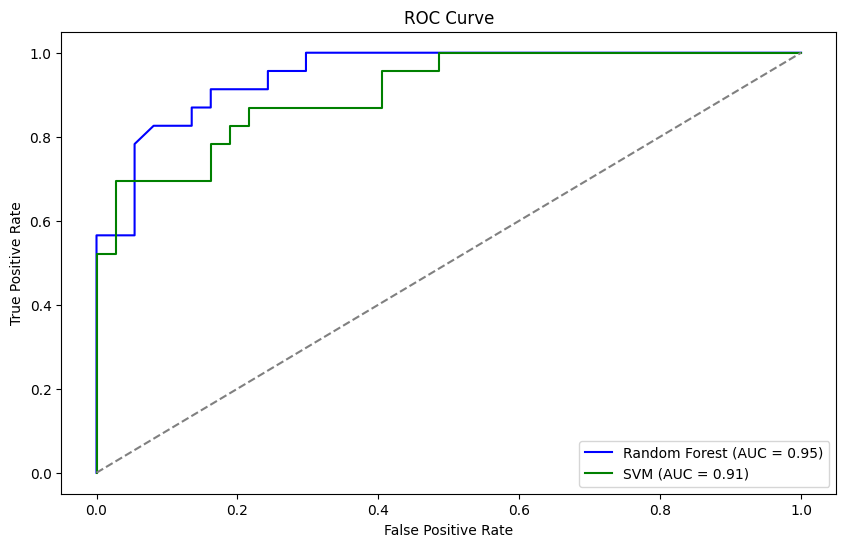

Without data augmentation
Class distribution after smothing:
DEATH_EVENT
0    166
1     73
Name: count, dtype: int64
Random Forest Accuracy: 0.85

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        37
           1       0.94      0.65      0.77        23

    accuracy                           0.85        60
   macro avg       0.88      0.81      0.83        60
weighted avg       0.86      0.85      0.84        60

Random Forest Confusion Matrix:
 [[36  1]
 [ 8 15]]

SVM Accuracy: 0.8

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.95      0.85        37
           1       0.87      0.57      0.68        23

    accuracy                           0.80        60
   macro avg       0.82      0.76      0.77        60
weighted avg       0.81      0.80      0.79        60

SVM Confusion Matrix:
 [[35  2]
 [10 13]]


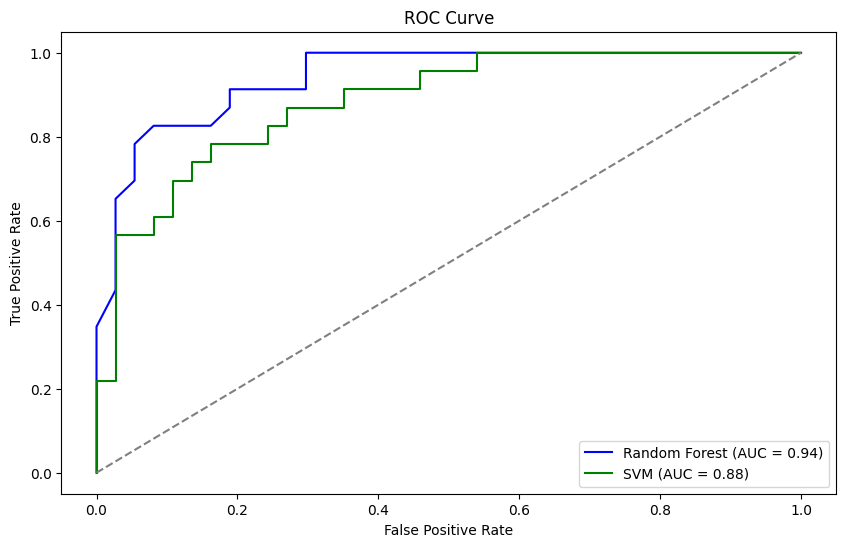

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load CSV Data
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/heart+failure+clinical+records/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(data_file)


# Define feature matrix (X) and target vector (y)
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # Last column as the target variable (mortality)

# Identify categorical columns and apply one-hot encoding

categorical_columns = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Count the number of samples in each class
class_counts = y.value_counts()
print(f"Class distribution before undersampling:\n{class_counts}")

#X = X.drop(X.columns[-1], axis=1)


"""
 Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Calculate VIF and remove features with high collinearity
vif = calculate_vif(X)
print("Initial VIF values:\n", vif)

# Set a threshold for VIF
vif_threshold = 5  # This threshold can be adjusted
while vif['VIF'].max() > vif_threshold:
    remove_feature = vif.sort_values('VIF', ascending=False)['Features'].iloc[0]
    print(f"Removing {remove_feature} with VIF: {vif['VIF'].max()}")
    X = X.drop(columns=remove_feature)
    vif = calculate_vif(X)

print("VIF after removal:\n", vif)
"""
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Apply SMOTE
smote = SMOTE(random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)


# Count the number of samples in each class
class_counts = y_train.value_counts()
print(f"Class distribution after smothing:\n{class_counts}")

# Standardize features for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest on the balanced data
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest and extract feature importances
rf_accuracy = accuracy_score(y_test, y_test_pred_rf)
print("Random Forest Accuracy:", rf_accuracy)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_test_pred_rf))

# Calculate and print confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)

# Plot ROC curve for Random Forest
rf_probs = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = roc_auc_score(y_test, rf_probs)

# Train SVM on the scaled data
svm_model = SVC(probability=True, random_state=0)
svm_model.fit(X_train, y_train)
y_test_pred_svm = svm_model.predict(X_test)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_test_pred_svm)
print("\nSVM Accuracy:", svm_accuracy)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_test_pred_svm))

# Calculate and print confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)
print("SVM Confusion Matrix:\n", conf_matrix_svm)

# Plot ROC curve for SVM
svm_probs = svm_model.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = roc_auc_score(y_test, svm_probs)

# Plot both ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, color='green', label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("Without data augmentation")
#without data augmentation
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Count the number of samples in each class
class_counts = y_train.value_counts()
print(f"Class distribution after smothing:\n{class_counts}")

# Standardize features for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest on the balanced data
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest and extract feature importances
rf_accuracy = accuracy_score(y_test, y_test_pred_rf)
print("Random Forest Accuracy:", rf_accuracy)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_test_pred_rf))

# Calculate and print confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)

# Plot ROC curve for Random Forest
rf_probs = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = roc_auc_score(y_test, rf_probs)

# Train SVM on the scaled data
svm_model = SVC(probability=True, random_state=0)
svm_model.fit(X_train, y_train)
y_test_pred_svm = svm_model.predict(X_test)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_test_pred_svm)
print("\nSVM Accuracy:", svm_accuracy)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_test_pred_svm))

# Calculate and print confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)
print("SVM Confusion Matrix:\n", conf_matrix_svm)

# Plot ROC curve for SVM
svm_probs = svm_model.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = roc_auc_score(y_test, svm_probs)

# Plot both ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, color='green', label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load CSV Data
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/heart+failure+clinical+records/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(data_file)

# Define feature matrix (X) and target vector (y)
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # Last column as the target variable (mortality)

# Split data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=0)  # 60% train, 20% val, 20% test

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Standardize features for consistency across models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize lists to store results
best_subset = None
best_auc = 0
all_results = []

# Iterate through all 3-feature combinations
for subset in combinations(X.columns, 4):
    # Select the current subset of features
    X_train_subset = X_train[:, [X.columns.get_loc(feature) for feature in subset]]
    X_val_subset = X_val[:, [X.columns.get_loc(feature) for feature in subset]]

    # Train a model on this subset
    rf_model = RandomForestClassifier(random_state=0)
    rf_model.fit(X_train_subset, y_train)

    # Predict and calculate AUC on validation set
    val_probs = rf_model.predict_proba(X_val_subset)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)

    # Store results
    all_results.append((subset, val_auc))
    if val_auc > best_auc:
        best_auc = val_auc
        best_subset = subset

# Print all subset performances on validation set
print("Performance of all 4-feature subsets on validation set:")
for subset, auc in all_results:
    print(f"Features: {subset}, AUC: {auc:.3f}")

print(f"\nBest Subset: {best_subset}, Best AUC on Validation: {best_auc:.3f}")

# Apply the best subset on the test set
X_train_best = X_train[:, [X.columns.get_loc(feature) for feature in best_subset]]
X_test_best = X_test[:, [X.columns.get_loc(feature) for feature in best_subset]]

# Retrain on the best subset
best_rf_model = RandomForestClassifier(random_state=0)
best_rf_model.fit(X_train_best, y_train)
# Get feature importances
feature_importances = best_rf_model.feature_importances_
print("Features Importance:", feature_importances)

colors = ['skyblue', 'salmon', 'lightgreen', 'gold']
# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.bar(best_subset, feature_importances, color=colors)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Features Importance Weights in Predicting Mortality')
plt.xticks(rotation=45)
plt.show()


# Retrain on the best subset
best_rf_model = RandomForestClassifier(random_state=0)
best_rf_model.fit(X_train_best, y_train)
test_probs = best_rf_model.predict_proba(X_test_best)[:, 1]
test_auc = roc_auc_score(y_test, test_probs)
# Print final performance on test set
print(f"\nFinal Performance on Test Set using Best Subset {best_subset}")
print(f"Test AUC: {test_auc:.3f}")
print("Classification Report on Test Set:")
print(classification_report(y_test, best_rf_model.predict(X_test_best)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, best_rf_model.predict(X_test_best))
print("Confusion Matrix:\n", conf_matrix)
# Plot confusion matrix
# Plot confusion matrix with color annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()


# Train SVM on the scaled data
svm_model = SVC(probability=True, random_state=0)
svm_model.fit(X_train_best, y_train)
y_test_pred_svm = svm_model.predict(X_test_best)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_test_pred_svm)
print("\nSVM Accuracy:", svm_accuracy)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_test_pred_svm))

# Calculate and print confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)
print("SVM Confusion Matrix:\n", conf_matrix_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()



#
# Fit the logistic regression model on selected features
logistic_model = LogisticRegression()
logistic_model.fit(X_train_best, y_train)
y_test_pred_log = logistic_model.predict(X_test_best)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_test_pred_log)
print("\nLogistic Regression Accuracy:", svm_accuracy)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_test_pred_log))

# Calculate and print confusion matrix
conf_matrix_log= confusion_matrix(y_test, y_test_pred_log)
print("Logistic Regression Confusion Matrix:\n", conf_matrix_log)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()

#RF ROC
test_probs = best_rf_model.predict_proba(X_test_best)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, test_probs)
roc_auc_rf = roc_auc_score(y_test, test_probs)
# Plot ROC curve for SVM
svm_probs = svm_model.predict_proba(X_test_best)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = roc_auc_score(y_test, svm_probs)
#Logistic regression
# Plot ROC curve for SVM
log_probs = logistic_model.predict_proba(X_test_best)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
roc_auc_log = roc_auc_score(y_test, log_probs)


# Plot both ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, color='green', label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_log, tpr_log, color='red', label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



print("Without Smoothing nor best features selection")
# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)



# Standardize features for consistency across models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# Apply the best subset on the test set
X_train_best = X_train
X_test_best = X_test

# Retrain on the best subset
best_rf_model = RandomForestClassifier(random_state=0)
best_rf_model.fit(X_train_best, y_train)


# Print final performance on test set
print(f"\nFinal Performance on Test Set using Best Subset {best_subset}")
print(f"Test AUC: {test_auc:.3f}")
print("Classification Report on Test Set:")
print(classification_report(y_test, best_rf_model.predict(X_test_best)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, best_rf_model.predict(X_test_best))
print("Confusion Matrix:\n", conf_matrix)
# Plot confusion matrix
# Plot confusion matrix with color annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()


# Train SVM on the scaled data
svm_model = SVC(probability=True, random_state=0)
svm_model.fit(X_train_best, y_train)
y_test_pred_svm = svm_model.predict(X_test_best)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_test_pred_svm)
print("\nSVM Accuracy:", svm_accuracy)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_test_pred_svm))

# Calculate and print confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)
print("SVM Confusion Matrix:\n", conf_matrix_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()



#
# Fit the logistic regression model on selected features
logistic_model = LogisticRegression()
logistic_model.fit(X_train_best, y_train)
y_test_pred_log = logistic_model.predict(X_test_best)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_test_pred_log)
print("\nLogistic Regression Accuracy:", svm_accuracy)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_test_pred_log))

# Calculate and print confusion matrix
conf_matrix_log= confusion_matrix(y_test, y_test_pred_log)
print("Logistic Regression Confusion Matrix:\n", conf_matrix_log)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()

#RF ROC
test_probs = best_rf_model.predict_proba(X_test_best)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, test_probs)
roc_auc_rf = roc_auc_score(y_test, test_probs)
# Plot ROC curve for SVM
svm_probs = svm_model.predict_proba(X_test_best)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = roc_auc_score(y_test, svm_probs)
#Logistic regression
# Plot ROC curve for SVM
log_probs = logistic_model.predict_proba(X_test_best)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
roc_auc_log = roc_auc_score(y_test, log_probs)


# Plot both ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, color='green', label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_log, tpr_log, color='red', label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()




# Get weights (coefficients)
#feature_weights = model.coef_
#print("Feature weights:", feature_weights)